Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## MNIST Feed-Forward Neural Network

In [1]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
import matplotlib.pyplot as plt
from torch.autograd import Variable 
from torch.utils import data

## Initilaize Data Loader

In [2]:
def MNIST_DATA(root='./data',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(), # convert data to tensor 
                                    download = True)  # whether to download the data
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download = True)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [3]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


## Define Trainer

In [4]:
from sklearn.metrics import confusion_matrix

class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Q1) what if we dind't clear up the gradients?
                #  A1) Whenever .background() is called, Pytorch accumulates the gradients in buffers on subsequent backward pass.
                #      If we didn't clear up them, it can be mixed with the previous gradients, and values can diverge
                #      when the number of iterations increases. So, if you don't want to mix up gradients between minibatches,
                #      you have to zero them out at the start of a new minibatch.

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() # Q2) Why should we change the network into eval-mode?
                        # A2) model.eval() sets the module in evaluation mode.
                        #     It is a kind of switch for some specific layers/parts (e.g. Dropout, BatchNorm) of the model
                        #     that behave differently during training and inference time.
                        #     For example, in eval mode the Dropout is deactivated and BatchNorm uses the parameters saved in training.
        test_loss = 0
        correct = 0
        error = 0
        
        # Data for confusion matrix
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
            error += (~pred.eq(labels.view_as(pred))).sum().item()

            test_loss /= len(self.testloader.dataset)
            
                
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
        
        
    def compute_conf(self):
        self.net.eval()
        
        # Data for confusion matrix
        conf_true = torch.zeros(0, dtype=torch.long, device='cpu')
        conf_pred = torch.zeros(0, dtype=torch.long, device='cpu')

        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            
            # Append batch prediction results for confusion matrix
            conf_true = torch.cat([conf_true, labels.view(-1).cpu()])
            conf_pred = torch.cat([conf_pred, pred.view(-1).cpu()])

        # Print confusion matrix
        label_name = [str(i) for i in range(10)]
        conf_mat = confusion_matrix(conf_true.numpy(), conf_pred.numpy(), labels=[i for i in range(10)])
        print('\nConfusion matrix\n')
        print(conf_mat)

        # confusion matrix figure
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i in range(10):
            for j in range(10):
                texts = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")
        cax = ax.matshow(conf_mat)
        fig.colorbar(cax)
        ax.set_xticks([i for i in range(10)])
        ax.set_yticks([i for i in range(10)])
        ax.set_xticklabels(label_name)
        ax.set_yticklabels(label_name)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

## Let's create Model by yourself

![activation](./imgs/activation.png)

### (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [5]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__() # Q3) Why do we need to call the constructor, nn.Module?
                                          # A3) torch.nn.Module is the base class for all neural network modules in Pytorch.
                                          #     If we want to create a class that holds our weights, bias, and method for the forward step,
                                          #     then nn.Module provides a number of attributes and methods for them.
                                          #     In order to create a custom network using Pytorch, therefore, the network need to
                                          #     inherit nn.Module.
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = F.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [6]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [7]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [8]:
trainer.train(epoch = 4)

C:\Users\Leki\Anaconda3\envs\assn1\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   500] loss: 2.321
[1,  1000] loss: 2.300
[1,  1500] loss: 2.283
[2,   500] loss: 2.263
[2,  1000] loss: 2.251
[2,  1500] loss: 2.240
[3,   500] loss: 2.219
[3,  1000] loss: 2.208
[3,  1500] loss: 2.194
[4,   500] loss: 2.170
[4,  1000] loss: 2.155
[4,  1500] loss: 2.139
Finished Training


In [9]:
trainer.test()


Test set:  Accuracy: 5507/10000 (55%)



### (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [10]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [11]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [12]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [13]:
trainer.train(epoch = 4)

[1,   500] loss: 2.280
[1,  1000] loss: 2.217
[1,  1500] loss: 2.123
[2,   500] loss: 1.896
[2,  1000] loss: 1.744
[2,  1500] loss: 1.589
[3,   500] loss: 1.323
[3,  1000] loss: 1.190
[3,  1500] loss: 1.072
[4,   500] loss: 0.918
[4,  1000] loss: 0.863
[4,  1500] loss: 0.802
Finished Training


In [14]:
trainer.test()


Test set:  Accuracy: 8469/10000 (85%)



#### Q4) Is there any difference in performance according to the activiation function?

#### Ans) Yes. When comparing inference of ReLU and Sigmoid in the same Network, the accuracy of ReLU is about 85%, which is better than 59% of Sigmoid. Sigmoid function has a problem in that when the output approaches 1 or 0 (saturated), the gradient approaches 0. Then, the gradients can't backpropagate through the network. The ReLU function is not saturated in positive region, so there is no vanishing gradient problem in positive region. It is also said that the convergence speed is about 6 times faster than that of the sigmoid function.

### (3) 3-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [15]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [16]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

In [17]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [18]:
trainer.train(epoch = 4)

[1,   500] loss: 2.317
[1,  1000] loss: 2.307
[1,  1500] loss: 2.303
[2,   500] loss: 2.301
[2,  1000] loss: 2.301
[2,  1500] loss: 2.300
[3,   500] loss: 2.299
[3,  1000] loss: 2.299
[3,  1500] loss: 2.299
[4,   500] loss: 2.298
[4,  1000] loss: 2.298
[4,  1500] loss: 2.298
Finished Training


In [19]:
trainer.test()


Test set:  Accuracy: 1135/10000 (11%)



#### Q5) Is training gets done easily? If it doesn't, why not?

#### Ans) No, it isn't. As mentioned in the answer of Q5, when using the sigmoid function saturated neuron kills the gradient. As the layer becomes deeper, therefore, layers at the front may not be updated due to the problem of vanishing gradient during backpropagation.

### (4) 3-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [20]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [21]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

In [22]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [23]:
trainer.train(epoch = 4)

[1,   500] loss: 2.300
[1,  1000] loss: 2.283
[1,  1500] loss: 2.264
[2,   500] loss: 2.212
[2,  1000] loss: 2.167
[2,  1500] loss: 2.111
[3,   500] loss: 1.965
[3,  1000] loss: 1.856
[3,  1500] loss: 1.737
[4,   500] loss: 1.519
[4,  1000] loss: 1.398
[4,  1500] loss: 1.281
Finished Training


In [24]:
trainer.test()


Test set:  Accuracy: 7471/10000 (75%)



#### Q6) Is training gets done easily compared to experiment (2)? If it doesn't, why not?

#### Ans) Yes. As mentioned in the answer of Q5, when using the ReLU function neurons are not saturated in positive region.

#### Q7) What would happen if there is no activation function?

#### Ans) If there is no activation function, the output signal would simply be a single linear function and it would be equal to linear classifier. Linear equation is easy to solve but it is limited in its complexity and hard to learn complex functional mapping from data. Introducing non-linear activation functions allows for the network to solve a larger variety of problems.

## Let's Change our Optimizer

![Adam](./imgs/adam.jpeg)

Reference: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

### (5) 3-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [25]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [26]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [27]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [28]:
trainer.train(epoch = 4)

[1,   500] loss: 0.620
[1,  1000] loss: 0.300
[1,  1500] loss: 0.230
[2,   500] loss: 0.190
[2,  1000] loss: 0.163
[2,  1500] loss: 0.150
[3,   500] loss: 0.125
[3,  1000] loss: 0.117
[3,  1500] loss: 0.121
[4,   500] loss: 0.097
[4,  1000] loss: 0.090
[4,  1500] loss: 0.101
Finished Training


In [29]:
trainer.test()


Test set:  Accuracy: 9663/10000 (97%)



### (6) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [30]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [31]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [32]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [33]:
trainer.train(epoch = 4)

[1,   500] loss: 0.690
[1,  1000] loss: 0.335
[1,  1500] loss: 0.292
[2,   500] loss: 0.246
[2,  1000] loss: 0.228
[2,  1500] loss: 0.210
[3,   500] loss: 0.193
[3,  1000] loss: 0.183
[3,  1500] loss: 0.164
[4,   500] loss: 0.149
[4,  1000] loss: 0.159
[4,  1500] loss: 0.154
Finished Training


In [34]:
trainer.test()


Test set:  Accuracy: 9558/10000 (96%)



## Batch-Normalization

![normalization](./imgs/normalization.png)

Reference: Andrew Ng, Deep Learning

### (7) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [35]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [36]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [37]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [38]:
trainer.train(epoch = 4)

[1,   500] loss: 0.728
[1,  1000] loss: 0.334
[1,  1500] loss: 0.293
[2,   500] loss: 0.221
[2,  1000] loss: 0.209
[2,  1500] loss: 0.198
[3,   500] loss: 0.175
[3,  1000] loss: 0.170
[3,  1500] loss: 0.162
[4,   500] loss: 0.148
[4,  1000] loss: 0.149
[4,  1500] loss: 0.145
Finished Training


In [39]:
trainer.test()


Test set:  Accuracy: 9648/10000 (96%)



### (8) 3-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [40]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.bn0 = nn.BatchNorm1d(50) # BatchNorm 1 
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) # BatchNorm 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [41]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [42]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [43]:
trainer.train(epoch = 4)

[1,   500] loss: 0.653
[1,  1000] loss: 0.261
[1,  1500] loss: 0.208
[2,   500] loss: 0.152
[2,  1000] loss: 0.143
[2,  1500] loss: 0.134
[3,   500] loss: 0.110
[3,  1000] loss: 0.119
[3,  1500] loss: 0.121
[4,   500] loss: 0.096
[4,  1000] loss: 0.099
[4,  1500] loss: 0.104
Finished Training


In [44]:
trainer.test()


Test set:  Accuracy: 9731/10000 (97%)



#### Q8) Is there any performance difference before/after applying the batch-norm?

#### Ans) A little bit. In the case of 2-layer network (comparing (7) with (6)), the performance of both is similar at 96%. In the case of a 3-layer network (comparing (8) with (5)), there is a 1% improvement in the performance from 97% to 98%.

#### Q9) How did 2-layer neural network and 3-layer neural network behave differently after applying the batch-nrom?

#### Ans) Comparing (8) with (7), there is a 2% improvement in the performance from 96% to 98%. As the number of layers increases, a vanishing gradient problem in which the gradient is not transmitted during backpropagation may occur. For this, there is a batch normalization technique that normalizes the distribution of batches in each layer. As the layer becomes deeper, the probability of occurrence of vanishing gradient problem increases, so the effect of batch normalization increases.

## HW 1.1 Let's Do It: Let's achieve performance greater than 98%!

In [45]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 8, 3, 1, 1)
        self.conv0_bn = nn.BatchNorm2d(8)
        self.pool0 = nn.MaxPool2d(2)
        self.dropout0 = nn.Dropout(0.25)

        self.conv1 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc = nn.Linear(16*7*7, 128)
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = self.dropout0(x)

        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x

In [46]:
mnist_net = MNIST_Net().cuda() # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [47]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epoch = 4)

[1,   500] loss: 0.443
[1,  1000] loss: 0.191
[1,  1500] loss: 0.148
[2,   500] loss: 0.107
[2,  1000] loss: 0.102
[2,  1500] loss: 0.104
[3,   500] loss: 0.086
[3,  1000] loss: 0.078
[3,  1500] loss: 0.077
[4,   500] loss: 0.070
[4,  1000] loss: 0.065
[4,  1500] loss: 0.067
Finished Training


In [48]:
trainer.test()


Test set:  Accuracy: 9897/10000 (99%)




Confusion matrix

[[ 977    0    0    0    0    0    2    1    0    0]
 [   0 1124    2    1    0    0    2    4    2    0]
 [   1    0 1020    1    0    0    0    8    2    0]
 [   0    0    1 1002    0    3    0    1    3    0]
 [   0    0    0    0  969    0    3    1    1    8]
 [   3    0    0    2    0  882    4    0    1    0]
 [   4    2    0    0    1    2  948    0    1    0]
 [   1    0    2    1    0    0    0 1021    2    1]
 [   2    0    1    1    1    1    0    0  965    3]
 [   0    0    0    1    6    5    0    4    4  989]]


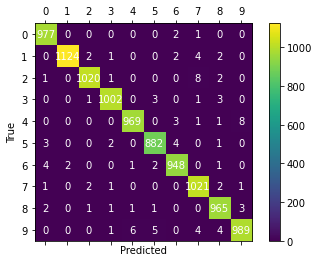

In [49]:
trainer.compute_conf()

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

103066

#### Q10) What are the problems with the large number of parameters?

#### Ans) Network that uses many parameters can represent more complicated functions because more can be expressed. Therefore, normally the more parameters, the better to the network. As the network gets bigger, however, the memory usage increases and . So, we need to adjust the network size to suit our resources. Also, overfitting can occur as the number of parameters increases. In this case, regularization should be strongly applied.

## Let's use Convolution Layer

### Convolution Operation

![Convolution](./imgs/Conv.png)



#### Q11) Given input image with shape:(H, W, C1), what would be the shape of output image after applying 2 (F * F) convolutional filters with stride S?
#### Ans)

### (9) 2-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [51]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [52]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [53]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [54]:
trainer.train(epoch = 4)

[1,   500] loss: 0.387
[1,  1000] loss: 0.170
[1,  1500] loss: 0.132
[2,   500] loss: 0.096
[2,  1000] loss: 0.085
[2,  1500] loss: 0.085
[3,   500] loss: 0.068
[3,  1000] loss: 0.065
[3,  1500] loss: 0.064
[4,   500] loss: 0.056
[4,  1000] loss: 0.055
[4,  1500] loss: 0.056
Finished Training


In [55]:
trainer.test()


Test set:  Accuracy: 9826/10000 (98%)



In [56]:
count_parameters(mnist_net)

11842

#### Q12) How did the performance and the number of parameters change after using the Convolution operation? Why did these results come out?

#### Ans) Comparing (9) with (7), the performance improved by 2% (96% -> 98%) and the number of parameters decreased by about 2 times. (23,920 -> 11,842) In the linear layer, as the size of the input increases, the number of weights used by the hidden layer increases. This can cause the problems mentioned in Q10. When the convolution layer is used, parameters are used as much as the size and the number of filters, so the number of parameters can be reduced while extracting features.

### (10) 2-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

![Pooling](./imgs/Pool.png)



In [57]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [58]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [59]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [60]:
trainer.train(epoch = 4)

[1,   500] loss: 0.554
[1,  1000] loss: 0.196
[1,  1500] loss: 0.155
[2,   500] loss: 0.114
[2,  1000] loss: 0.104
[2,  1500] loss: 0.100
[3,   500] loss: 0.089
[3,  1000] loss: 0.084
[3,  1500] loss: 0.082
[4,   500] loss: 0.077
[4,  1000] loss: 0.076
[4,  1500] loss: 0.075
Finished Training


In [61]:
trainer.test()


Test set:  Accuracy: 9771/10000 (98%)



In [62]:
count_parameters(mnist_net)

3202

#### Q13) How did the performance change after using the Convolution operation? Why did these results come out?

#### Ans) Comparing (10) with (9), the performance is similar, but the number of parameters is significantly reduced. (11842 -> 3202) When using a 2D pooling layer, the number of channels is maintained, and the width and height of the input are reduced by extracting the features of each part of the input. This reduces the number of parameters of the network to suppress overfitting problem and reduce memory usage. Also, since the pooling layer has no parameters to be trained, it does not affect the total number of parameters of the network.